## 状態空間モデルで時系列予測を行う〜線形ガウスモデルのトレンド推定モデル〜（pykalman）

In [1]:
%load_ext lab_black

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import requests
import io
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import minimize
from pykalman import KalmanFilter

In [3]:
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
passengers = pd.read_csv(io.StringIO(stream.decode("utf-8")))

<AxesSubplot:>

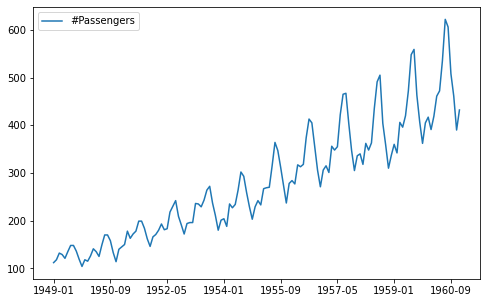

In [4]:
passengers.plot(x="Month", y="#Passengers", figsize=(8, 5), xlabel="")

In [5]:
y = pd.Series(
    passengers["#Passengers"].values,
    index=pd.to_datetime(passengers["Month"], infer_datetime_format=True),
)
y = y.astype(float)

n_train = 120
train_data, test_data = y.values[:n_train], y.values[n_train:]

### 状態空間モデルの構築　〜トレンド推定モデル〜

In [6]:
n_dim_obs = 1  # 観測値の次元数
n_dim_trend = 2  # トレンドの次元数（状態の次元数）
n_dim_state = n_dim_trend

F = np.array([[2, -1], [1, 0]], dtype=float)

G = np.array([[1], [0]], dtype=float)

H = np.array([[1, 0]], dtype=float)

Q = np.eye(1) * 10
Q = G.dot(Q).dot(G.T)

state_mean = np.zeros(n_dim_state)  # 状態の平均値ベクトルの初期値
state_cov = np.ones((n_dim_state, n_dim_state))  # 状態の分散共分散行列の初期値

In [7]:
kf = KalmanFilter(
    n_dim_obs=n_dim_obs,
    n_dim_state=n_dim_state,
    initial_state_mean=state_mean,
    initial_state_covariance=state_cov,
    transition_matrices=F,
    transition_covariance=Q,
    observation_matrices=H,
    observation_covariance=1.0,
)

#### トレンド推定モデルの推定結果を確認　〜平滑化〜

In [8]:
state_means, state_covs = kf.smooth(train_data)

In [9]:
print("状態の平均値 : \n{} \n\n 状態の共分散 : \n{}".format(state_means[:5], state_covs[:5]))

状態の平均値 : 
[[ 59.91298572  59.91298572]
 [109.5795155   59.91298572]
 [130.65286077 109.5795155 ]
 [129.07815222 130.65286077]
 [124.27191284 129.07815222]] 

 状態の共分散 : 
[[[0.46665682 0.46665682]
  [0.46665682 0.46665682]]

 [[0.68255688 0.08557686]
  [0.08557686 0.46665682]]

 [[0.70876804 0.16497966]
  [0.16497966 0.68255688]]

 [[0.708719   0.16623918]
  [0.16623918 0.70876804]]

 [[0.70879048 0.16614292]
  [0.16614292 0.708719  ]]]


In [10]:
ovsevation_means_predicted = state_means.dot(H.T)

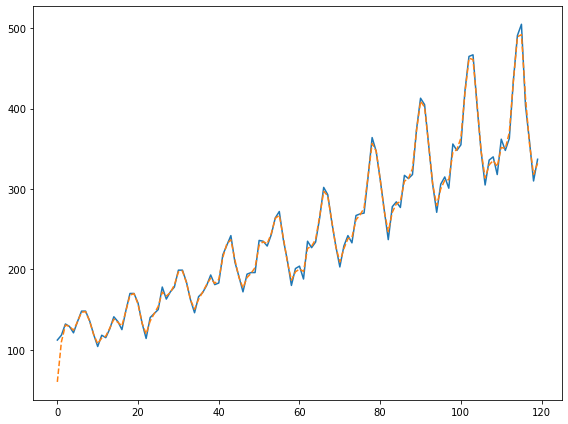

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(train_data, label="observation")
plt.plot(ovsevation_means_predicted, "--", label="forecast")
plt.tight_layout()

#### トレンド推定モデルの結果確認　〜フィルタリングと１期先予測〜

In [12]:
train_data, test_data = y[:n_train], y[n_train:]

state_means, state_covs = kf.smooth(train_data)
ovsevation_means_predicted = np.dot(state_means, kf.observation_matrices.T)

current_state = state_means[-1]
current_cov = state_covs[-1]

pred_means = np.array([])
for i in range(len(test_data)):

    current_state, current_cov = kf.filter_update(
        current_state, current_cov, observation=None
    )
    pred_mean = kf.observation_matrices.dot(current_state)
    pred_means = np.r_[pred_means, pred_mean]

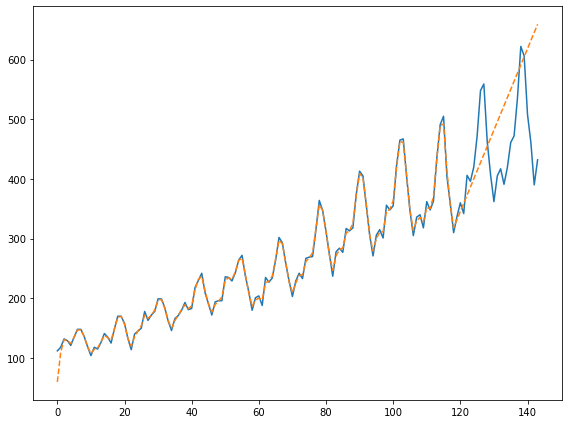

In [13]:
plt.figure(figsize=(8, 6))
plt.plot(y.values, label="observation")
plt.plot(
    np.hstack([ovsevation_means_predicted.flatten(), np.array(pred_means).flatten()]),
    "--",
    label="forecast",
)
plt.tight_layout()

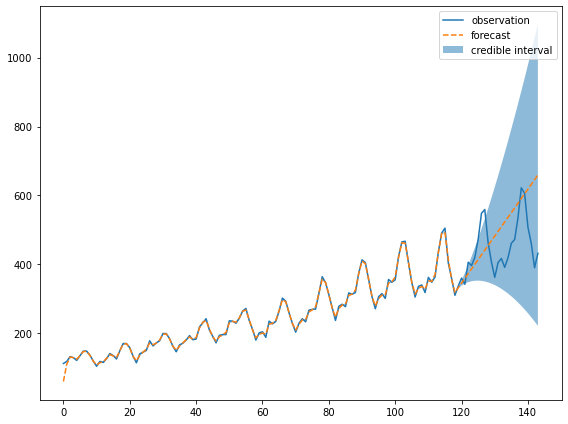

In [14]:
train_data, test_data = y[:n_train], y[n_train:]

state_means, state_covs = kf.smooth(train_data)
ovsevation_means_predicted = np.dot(state_means, kf.observation_matrices.T)
ovsevation_covs_predicted = (
    kf.observation_matrices.dot(np.abs(state_covs))
    .transpose(1, 0, 2)
    .dot(kf.observation_matrices.T)
)

lowers, uppers = scipy.stats.norm.interval(
    0.95,
    ovsevation_means_predicted.flatten(),
    scale=np.sqrt(ovsevation_covs_predicted.flatten()),
)

current_state = state_means[-1]
current_cov = state_covs[-1]

pred_means = np.array([])
tmp_lowers = []
tmp_uppers = []
for i in range(len(test_data)):

    current_state, current_cov = kf.filter_update(
        current_state, current_cov, observation=None
    )
    pred_mean = current_state.dot(kf.observation_matrices.T)
    pred_cov = kf.observation_matrices.dot(np.abs(current_cov)).dot(
        kf.observation_matrices.T
    )

    pred_means = np.r_[pred_means, pred_mean]

    lower, upper = scipy.stats.norm.interval(0.95, pred_mean, scale=np.sqrt(pred_cov))
    tmp_lowers.append(lower)
    tmp_uppers.append(upper)

lowers = np.hstack([lowers, np.array(tmp_lowers).flatten()])
uppers = np.hstack([uppers, np.array(tmp_uppers).flatten()])

plt.figure(figsize=(8, 6))
plt.plot(y.values, label="observation")
plt.plot(
    np.hstack([ovsevation_means_predicted.flatten(), pred_means.flatten()]),
    "--",
    label="forecast",
)

plt.fill_between(range(len(y)), uppers, lowers, alpha=0.5, label="credible interval")
plt.legend()
plt.tight_layout()